In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss,f1_score
from tqdm import tqdm
import time
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from numpy.linalg import norm

### Iris Dataset

In [72]:
iris=load_iris()
data = iris.data[:,:]  # take only the first two features
labels = iris.target

In [73]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

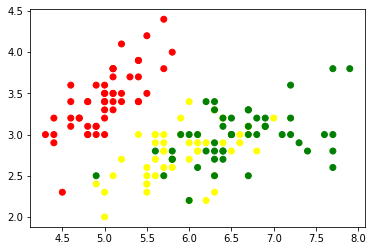

In [74]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [75]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (150, 4)
Labels shape (150,)


In [76]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(120, 4) (30, 4) (150,)


In [77]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(120, 3) (30, 3)


In [80]:
class FF:
  
  def __init__(self,init_method = 'xavier'):

    self.K_matrix = np.array([])

    if init_method == "random":
      self.W1 = np.random.randn(4,4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,3)
      self.B2 = np.random.randn(1,3) 

      self.K = np.random.randn(3,1)

    elif init_method == "he":
      self.W1 = np.random.randn(4,4)*np.sqrt(2/4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,3)*np.sqrt(2/4)
      self.B2 = np.random.randn(1,3) 

      self.K = np.random.randn(3,1)*np.sqrt(2/3)
  
    elif init_method == "xavier":
      self.W1 = np.random.randn(4,4)*np.sqrt(1/4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,3)*np.sqrt(1/4)
      self.B2 = np.random.randn(1,3) 

      self.K = np.random.randn(3,1)*np.sqrt(2)

  def act_fun(self, X):
    return K[0] + K[1]*X
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.Z1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.A1 = self.act_fun(self.Z1) # (N, 2)
    self.Z2 = np.matmul(self.A1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.A2 = self.softmax(self.Z2) # (N, 4)
    return self.A2
    
  def grad_act_fun(self, X):
    return K[1] 

  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val

  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dZ2 = self.A2 - Y # (N, 4) - (N, 4) -> (N, 4)

    self.dW2 = np.matmul(self.A1.T/m, self.dZ2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.average(self.dZ2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dA1 = np.matmul(self.dZ2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dZ1 = np.multiply(self.dA1, self.grad_act_fun(self.A1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.average(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
    self.dK = []
    self.dK.append([np.average(self.A1)])
    self.dK.append([np.average(np.multiply(self.dA1,self.Z1))])
    self.dK.append([np.average(np.multiply(self.dA1,np.square(self.Z1)))])
    self.dK = np.asarray(self.dK)
    
  def fit(self, X, Y, epochs=1, learning_rate=1,search = True, display_loss=False):
    while search:
      best = 0
      train_accuracies={}
      val_accuracies={}
    
      if display_loss:
        loss = {}
        K0 = {}
        K1 = {}
      for i in tqdm(range(epochs), total=epochs, unit="epoch"):
        self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        m = X.shape[0]
        self.W2 -= learning_rate * (self.dW2)
        self.B2 -= learning_rate * (self.dB2)
        self.W1 -= learning_rate * (self.dW1)
        self.B1 -= learning_rate * (self.dB1)
        self.K  -= learning_rate * (self.dK)

        train_accuracy,val_accuracy=self.get_accuracy()
        train_accuracies[i]=train_accuracy
        val_accuracies[i]=val_accuracy

        if train_accuracy>best:
          best = train_accuracy
          best_K0 = self.K[0]
          best_K1 = self.K[1]
        
        if display_loss:
          K0[i] = self.K[0]
          K1[i] = self.K[1]
          Y_pred = self.predict(X)
          loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
      print("Best K0 value:{}",best_K0)
      print("Best K1 value:{}",best_K1)
      print_accuracy()
      plt.plot(list(train_accuracies.values()),label="Train accuracy")
      plt.plot(list(val_accuracies.values()),label="Validation accuracy")
      plt.plot(np.ones((epochs, 1))*0.9)
      plt.plot(np.ones((epochs, 1))*0.33)
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()
      if display_loss:
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('Log Loss', color=color)
        ax1.plot(np.array(list(loss.values())).astype(float), '-o', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('K0 value', color=color)  # we already handled the x-label with ax1
        ax2.plot(np.array(list(K0.values())).astype(float), '-*', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax3 = ax1.twinx()  
        color = 'tab:green'
        ax3.set_ylabel('K1 value', color=color)  # we already handled the x-label with ax1
        ax3.plot(np.array(list(K1.values())).astype(float), '--', color=color)
        ax3.tick_params(axis='y', labelcolor=color)
      
        fig.tight_layout()  
        plt.show()
      if best*100>80:
        print_accuracy()
        search = False
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
  def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    score = f1_score(Y_val, Y_pred_val,average='micro')
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    print("F1 Score value",score)
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

100%|██████████| 100/100 [00:00<00:00, 942.70epoch/s]


Best K0 value:{} [-2.30773961]
Best K1 value:{} [-0.56822378]
Training accuracy 0.5333
Validation accuracy 0.6333


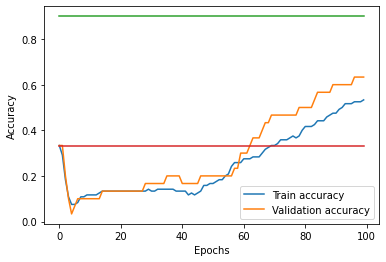

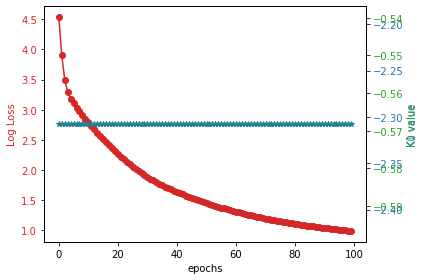

100%|██████████| 100/100 [00:00<00:00, 1018.93epoch/s]


Best K0 value:{} [-2.30007346]
Best K1 value:{} [-0.56642683]
Training accuracy 0.6667
Validation accuracy 0.7333


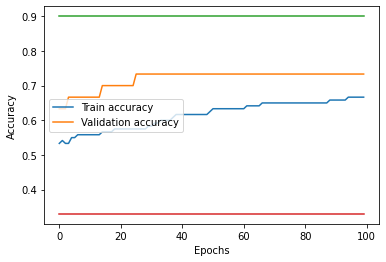

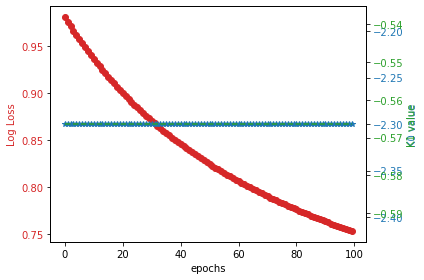

100%|██████████| 100/100 [00:00<00:00, 863.16epoch/s]


Best K0 value:{} [-2.29266706]
Best K1 value:{} [-0.56484652]
Training accuracy 0.7
Validation accuracy 0.8


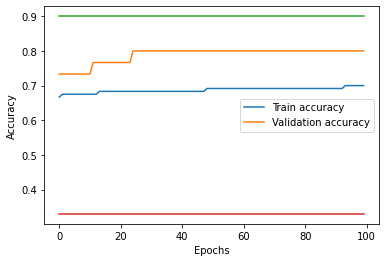

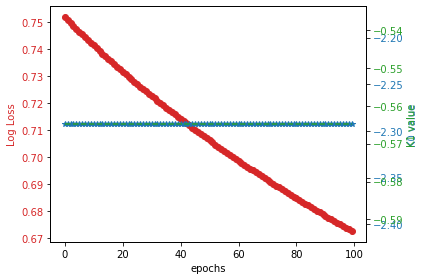

100%|██████████| 100/100 [00:00<00:00, 852.84epoch/s]


Best K0 value:{} [-2.28553955]
Best K1 value:{} [-0.56337174]
Training accuracy 0.7417
Validation accuracy 0.8


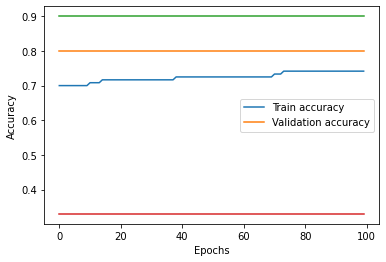

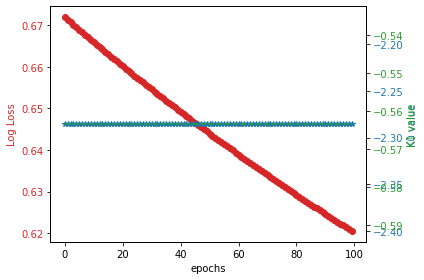

100%|██████████| 100/100 [00:00<00:00, 848.99epoch/s]


Best K0 value:{} [-2.27864165]
Best K1 value:{} [-0.56194731]
Training accuracy 0.7583
Validation accuracy 0.8


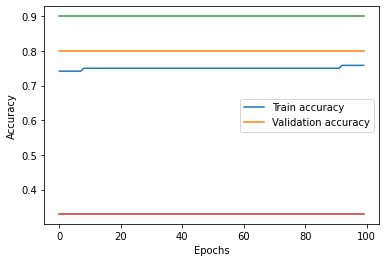

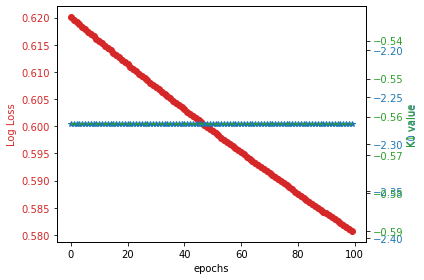

100%|██████████| 100/100 [00:00<00:00, 904.59epoch/s]


Best K0 value:{} [-2.27194908]
Best K1 value:{} [-0.56055122]
Training accuracy 0.775
Validation accuracy 0.8


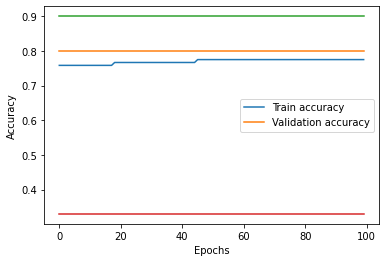

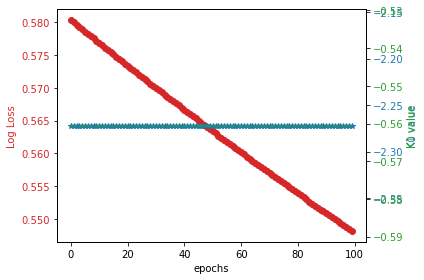

100%|██████████| 100/100 [00:00<00:00, 1040.77epoch/s]


Best K0 value:{} [-2.26545079]
Best K1 value:{} [-0.55917384]
Training accuracy 0.7917
Validation accuracy 0.8333


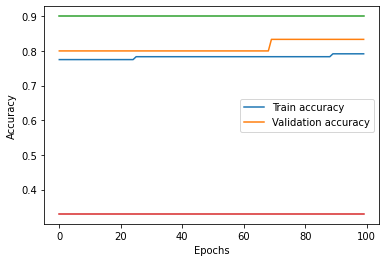

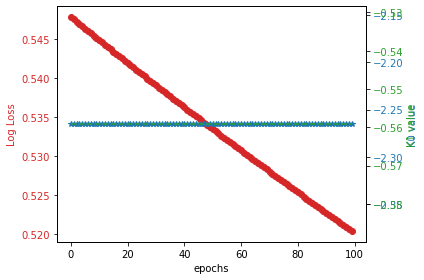

100%|██████████| 100/100 [00:00<00:00, 935.70epoch/s]


Best K0 value:{} [-2.2591406]
Best K1 value:{} [-0.5578109]
Training accuracy 0.8
Validation accuracy 0.9


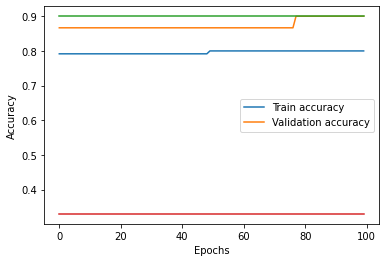

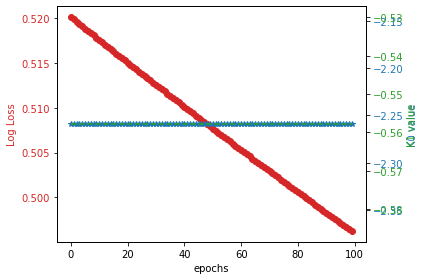

100%|██████████| 100/100 [00:00<00:00, 900.22epoch/s]


Best K0 value:{} [-2.25301365]
Best K1 value:{} [-0.55646075]
Training accuracy 0.8
Validation accuracy 0.9


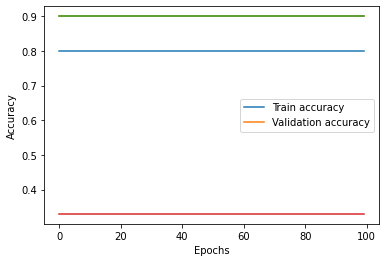

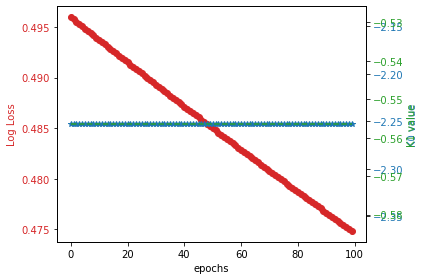

100%|██████████| 100/100 [00:00<00:00, 920.45epoch/s]


Best K0 value:{} [-2.24706515]
Best K1 value:{} [-0.55512308]
Training accuracy 0.825
Validation accuracy 0.9


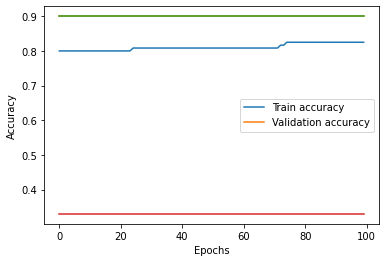

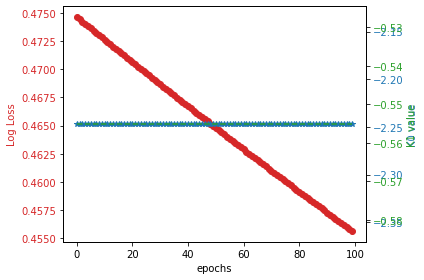

Training accuracy 0.825
Validation accuracy 0.9
Training accuracy 0.825
Validation accuracy 0.9
Time taken by model: 6.240441083908081


In [83]:
tic = time.time()
model = FF()
model.fit(X_train, y_OH_train, epochs=100,learning_rate=0.0001,display_loss=True)
print_accuracy()
toc = time.time()
print("Time taken by model: {}".format(toc-tic))

### Bank Note Dataset

In [88]:
from pandas import read_csv
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/banknote_authentication.csv'
df = read_csv(url, header=None)
print(df.shape)

(1372, 5)


In [94]:
X, y = df.values[:, :-1], df.values[:, -1]
X = X.astype('float32')
y = LabelEncoder().fit_transform(y)
X_train, X_val, Y_train, Y_val = train_test_split(X,y, random_state=0,test_size=0.3)
print(X_train.shape, X_val.shape,Y_train.shape)

(960, 4) (412, 4) (960,)


In [97]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(960, 2) (412, 2)


In [98]:
class FF:
  
  def __init__(self,init_method = 'xavier'):

    self.K_matrix = np.array([])

    if init_method == "random":
      self.W1 = np.random.randn(4,4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,2)
      self.B2 = np.random.randn(1,2) 

      self.K = np.random.randn(3,1)

    elif init_method == "he":
      self.W1 = np.random.randn(4,4)*np.sqrt(2/4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,2)*np.sqrt(2/4)
      self.B2 = np.random.randn(1,2) 

      self.K = np.random.randn(3,1)*np.sqrt(2/3)
  
    elif init_method == "xavier":
      self.W1 = np.random.randn(4,4)*np.sqrt(1/4)
      self.B1 = np.random.randn(1,4)

      self.W2 = np.random.randn(4,2)*np.sqrt(1/4)
      self.B2 = np.random.randn(1,2) 

      self.K = np.random.randn(3,1)*np.sqrt(2)

  def act_fun(self, X):
    return K[0] + K[1]*X
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.Z1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.A1 = self.act_fun(self.Z1) # (N, 2)
    self.Z2 = np.matmul(self.A1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.A2 = self.softmax(self.Z2) # (N, 4)
    return self.A2
    
  def grad_act_fun(self, X):
    return K[1] 

  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val

  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dZ2 = self.A2 - Y # (N, 4) - (N, 4) -> (N, 4)

    self.dW2 = np.matmul(self.A1.T/m, self.dZ2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.average(self.dZ2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dA1 = np.matmul(self.dZ2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dZ1 = np.multiply(self.dA1, self.grad_act_fun(self.A1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.average(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
    self.dK = []
    self.dK.append([np.average(self.A1)])
    self.dK.append([np.average(np.multiply(self.dA1,self.Z1))])
    self.dK.append([np.average(np.multiply(self.dA1,np.square(self.Z1)))])
    self.dK = np.asarray(self.dK)
    
  def fit(self, X, Y, epochs=1, learning_rate=1,search = True, display_loss=False):
    while search:
      best = 0
      train_accuracies={}
      val_accuracies={}
    
      if display_loss:
        loss = {}
        K0 = {}
        K1 = {}
      for i in tqdm(range(epochs), total=epochs, unit="epoch"):
        self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        m = X.shape[0]
        self.W2 -= learning_rate * (self.dW2)
        self.B2 -= learning_rate * (self.dB2)
        self.W1 -= learning_rate * (self.dW1)
        self.B1 -= learning_rate * (self.dB1)
        self.K  -= learning_rate * (self.dK)

        train_accuracy,val_accuracy=self.get_accuracy()
        train_accuracies[i]=train_accuracy
        val_accuracies[i]=val_accuracy

        if train_accuracy>best:
          best = train_accuracy
          best_K0 = self.K[0]
          best_K1 = self.K[1]
        
        if display_loss:
          K0[i] = self.K[0]
          K1[i] = self.K[1]
          Y_pred = self.predict(X)
          loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
      print("Best K0 value:{}",best_K0)
      print("Best K1 value:{}",best_K1)
      print_accuracy()
      plt.plot(list(train_accuracies.values()),label="Train accuracy")
      plt.plot(list(val_accuracies.values()),label="Validation accuracy")
      plt.plot(np.ones((epochs, 1))*0.9)
      plt.plot(np.ones((epochs, 1))*0.33)
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()
      if display_loss:
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('Log Loss', color=color)
        ax1.plot(np.array(list(loss.values())).astype(float), '-o', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('K0 value', color=color)  # we already handled the x-label with ax1
        ax2.plot(np.array(list(K0.values())).astype(float), '-*', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax3 = ax1.twinx()  
        color = 'tab:green'
        ax3.set_ylabel('K1 value', color=color)  # we already handled the x-label with ax1
        ax3.plot(np.array(list(K1.values())).astype(float), '--', color=color)
        ax3.tick_params(axis='y', labelcolor=color)
      
        fig.tight_layout()  
        plt.show()
      if best*100>80:
        print_accuracy()
        search = False
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
  def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    score = f1_score(Y_val, Y_pred_val,average='micro')
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    print("F1 Score value",score)
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

100%|██████████| 100/100 [00:00<00:00, 588.50epoch/s]


Best K0 value:{} [-1.2147062]
Best K1 value:{} [0.92316113]
Training accuracy 0.7979
Validation accuracy 0.7888


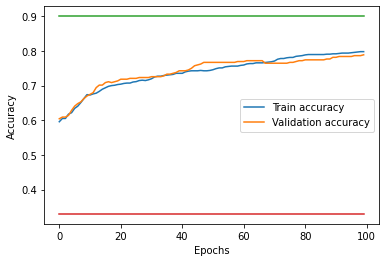

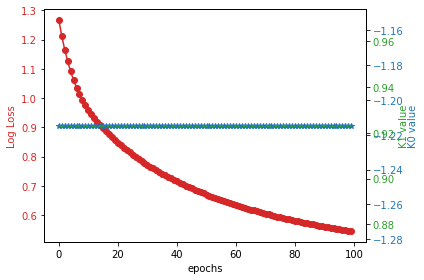

100%|██████████| 100/100 [00:00<00:00, 589.68epoch/s]


Best K0 value:{} [-1.18849356]
Best K1 value:{} [0.92389735]
Training accuracy 0.8448
Validation accuracy 0.8398


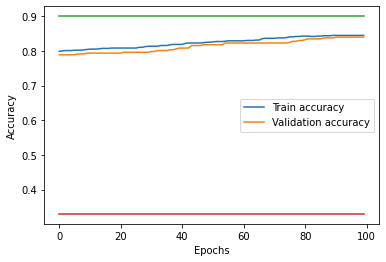

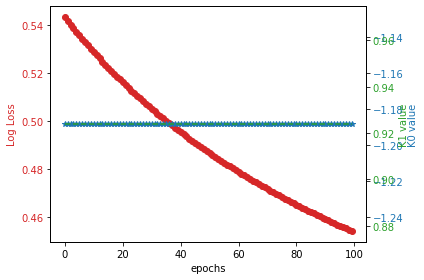

Training accuracy 0.8448
Validation accuracy 0.8398
Training accuracy 0.8448
Validation accuracy 0.8398
Time taken by model: 1.418503761291504


In [99]:
tic = time.time()
model = FF()
model.fit(X_train, y_OH_train, epochs=100,learning_rate=0.0001,display_loss=True)
print_accuracy()
toc = time.time()
print("Time taken by model: {}".format(toc-tic))